In [22]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

### Mathematical model

We have $N$ of oscillators with natural frequency $\omega_i$ and a phase angle $\phi_i$.

The coupling the evolution (ODE) is now given by

\begin{equation}
     \dot \phi_i = \omega_i + \sum_{j\neq i} k_{ij} \sin(\phi_j-\phi_i-\alpha) + \eta_i
\end{equation}

where the $k_{ij}$ are the coupling constants, $\alpha$ is the phase delay and $\eta_i$ is standard white noise.

We take here $\alpha=0$, $k_{ij}=k$, $\omega_i=\omega$ and no noise: 

\begin{equation}
     \dot \phi_i = \omega +  k \sum_{j\neq i}\sin(\phi_j-\phi_i)
\end{equation}

### Visualizations

(1) By considering $e^{i\phi_i}$ we can visualise the evolution on the unit circle.

(2) The interaction is given through the so-called *order parameter*

\begin{equation}
    r = \frac 1N \sum_{j=1}^N e^{i\phi_j} 
\end{equation}

which is also used to measure the degree of synchronisation. This is is just the mean of all the oscillators.

### Numerical solutions

**[Runge-Kutta]**

Following https://laszukdawid.com/2017/03/02/kuramoto-in-python/, we use scipy integration ODE, with 'dopri5' (explicit runge-kutta method of order (4)5.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html

Hairer, Norsett, Wanner_Solving Ordinary Differential Equations.


**[explicit Euler]**

From https://hdietert.github.io/static/kuramoto-animation/kuramoto.html, a simple forward Euler scheme (explicit) should be enough to numerical solve the ODE. If

\begin{eqnarray}
        \dot y(t) = f(t, y(t)) \quad \text{and} \quad y(t_0) = y_0 \\
\end{eqnarray}

then  by setting $t_{n+1} = h + t_n $ we have

\begin{eqnarray}
        y_{n+1} = y_{n} + h f(t_n, y_n).
\end{eqnarray}




#### set visualizations

In [23]:
import matplotlib.pyplot as plt

def viz_kuramoto(phase, T, dt):

    nb = phase.shape[0]
    dot_phase = np.diff(phase)/dt
    r = (1/float(nb))*np.exp(1j*phase).sum(axis=0)
    
    fig, axes = plt.subplots(nrows=nb+1, ncols=1, figsize=(12, 10))

    for comp in range(nb):
        axes[comp].plot(T, phase[comp],'b-')
        axes[comp].set_title('$\phi_%i(t)$'%(comp+1))
        axes[comp].set_ylim(phase.min(), phase.max())

    axes[nb].plot(T, r.real,'g-', label='Re[r_(t)]')
    axes[nb].plot(T, r.imag,'c-', label='Im[r_(t)]')
    axes[nb].plot(T, np.abs(r),'y-', label='|r(t)|')
    axes[nb].set_ylim(-np.abs(r).max()-0.2, np.abs(r).max()+0.2)
    axes[nb].set_title('Order parameter r')
    axes[nb].legend()

    fig_a, ax_a = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    ax_a.set_title('Order parameter r')
    ax_a.scatter(r.real, r.imag, c='y')
    ax_a.set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()

#### define initial values and parameters

In [24]:
import numpy as np

dtype = np.float32

t0, t1, dt = 0, 20, 0.01
T = np.arange(t0, t1, dt)

seed = 666
rnd = np.random.RandomState(seed)

nb_oscilators = 5
init_phase = 2*np.pi*rnd.random_sample(size=nb_oscilators)
W = 1
K = 10/float(nb_oscilators) 

print(init_phase)

[4.40097623 5.30418111 4.25066494 4.57326705 5.97818666]


## [Runge-Kutta]

#### define problem to integrate (right hand size of ODE)

In [25]:
def kuramoto_ODE(t, y, arg):
    """General Kuramoto ODE of m'th harmonic order.
       Argument `arg` = (w, k), with
        w -- iterable frequency
        k -- 3D coupling matrix, unless 1st order
        """
    w, k = arg
    yt = y[:, None]
    dy = y - yt
    phase = float(w)
    # add noise
    # phase += 0.0001*np.random.uniform(len(phase))
    phase += np.sum(k*np.sin(dy), axis=1)
    return phase

#### define scipy integrator

In [26]:
from scipy.integrate import ode

# Set ODE integrator (explicit runge-kutta method of order (4)5)
kODE = ode(kuramoto_ODE)
kODE.set_integrator("dopri5")

# Set parameters into model
kODE.set_initial_value(init_phase, T[0])
kODE.set_f_params((W, K))

#### do the integration

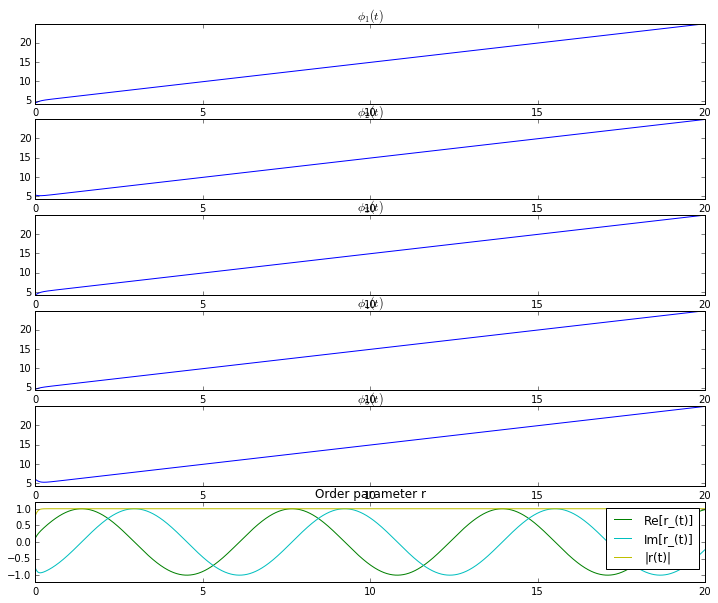

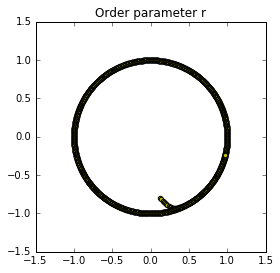

In [27]:
# Run ODE integrator
y = np.empty((nb_oscilators, len(T)))
for idx, _t in enumerate(T[1:]):
    y[:,idx] = kODE.y
    kODE.integrate(_t)
y[:,-1] = kODE.y

viz_kuramoto(y, T, dt)

## [explicit Euler]

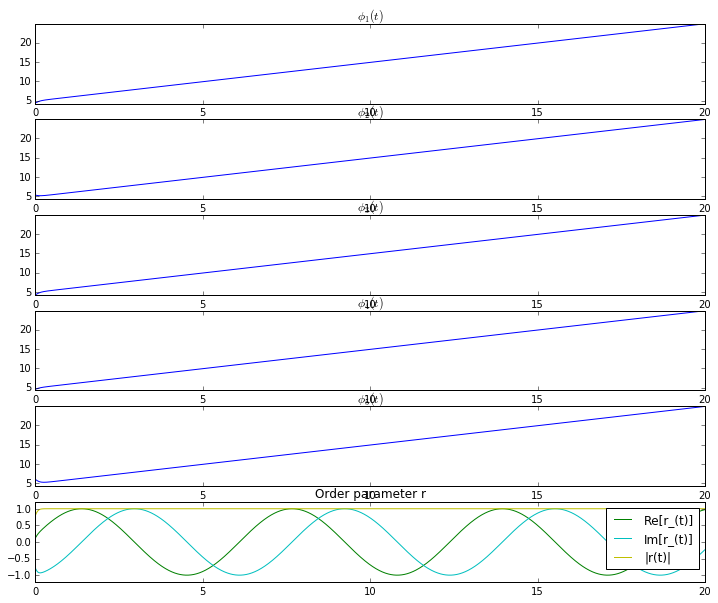

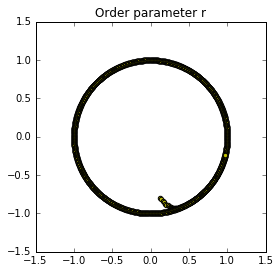

In [28]:
def kuramoto_ODE(t, y, arg):
    """General Kuramoto ODE of m'th harmonic order.
       Argument `arg` = (w, k), with
        w -- iterable frequency
        k -- 3D coupling matrix, unless 1st order
        """
    w, k = arg
    yt = y[:, None]
    dy = y - yt
    phase = float(w)
    # add noise
    # phase += 0.0001*np.random.uniform(len(phase))
    phase += np.sum(k*np.sin(dy), axis=1)
    return phase


def f(y):
    out = float(W)*np.ones_like(y)
    # add noise
    # phase += 0.0001*np.random.uniform(len(phase))
    for i in range(len(y)):
        for j in range(len(y)):
            out[i] += K*np.sin(y[j] - y[i])
    return out

y = np.empty((nb_oscilators, len(T)))
y[:, 0] = init_phase
for idx in range(1, len(T)):
    y[:, idx] = y[:,idx-1] + dt*f(y[:,idx-1])

viz_kuramoto(y, T, dt)

## [microcontroller Euler]

/Users/JRLetelier/Desktop/synchro_chaotique/src/666.log
/Users/JRLetelier/Desktop/synchro_chaotique/src/777.log
/Users/JRLetelier/Desktop/synchro_chaotique/src/888.log


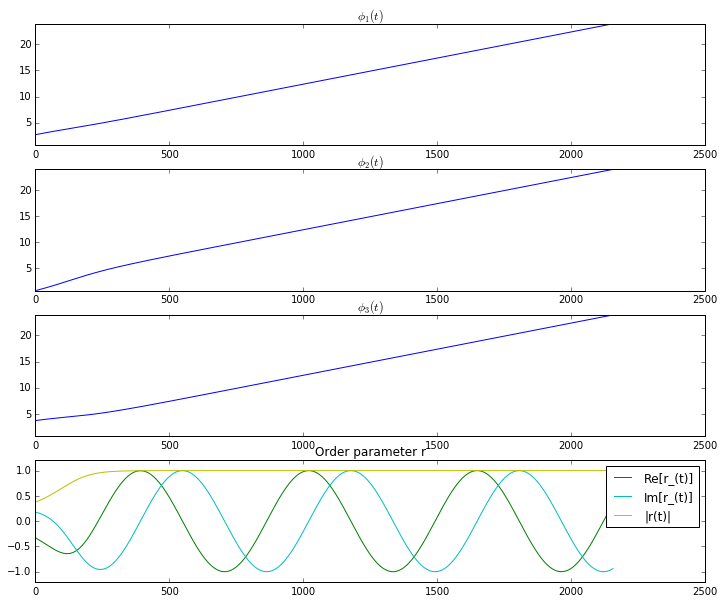

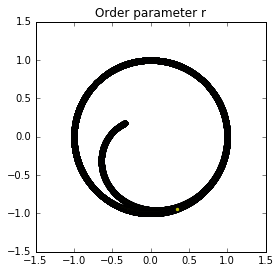

In [29]:
import pandas

logs = []
for port in [666, 777, 888]:
    path = '/Users/JRLetelier/Desktop/synchro_chaotique/src/%i.log' % port
    with open(path, 'r') as f:
        print path
        lines = f.readlines()
        logs.append([float(l[:-1].split(' ')[1]) for l in lines
                     if not l.startswith('MicroController') and len(l[:-1].split(' ')) > 1])

min_length = np.min([len(l) for l in logs])
logs = [l[:min_length] for l in logs]

y = np.empty((len(logs), min_length), dtype=np.float32)
dt = 0.1

for i in range(len(logs)):
    y[i, :] = logs[i]

    
T = np.array([dt*i for i in range(y.shape[1])])

viz_kuramoto(y, T, dt)